In [168]:
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

"""
Preparing data
"""

X, y = datasets.make_classification(n_samples=1000,n_features = 20, n_classes = 2, n_informative = 3)

# add noise
noise = 0.2
X += X + noise * (X.max() - X.min()/2) * np.random.randn(X.shape[0],X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

print('Train set:  features',X_train.shape[1],'samples',X_train.shape[0])
print('Test  set:  features',X_test.shape[1],'samples',X_test.shape[0])

Train set:  features 20 samples 750
Test  set:  features 20 samples 250


In [156]:
class BlendingClassifier:

    """
    Hold-out stacking
    clfs - list of base classifiers
    meta  - model of meta classifier
    test_ratio - training / test split ratio
    join_feat - join basic and meta features in train dataset if True 
    """
    
    def __init__(self, clfs, meta, test_ratio = 0.25, join_feat = False):

        self.clfs = clfs
        self.meta = meta
        self.test_ratio = test_ratio
        self.join_feat = join_feat
        
    def fit(self, X, y):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_ratio)
        X_meta  = np.zeros((X_test.shape[0], len(self.clfs)))
            
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            X_meta[:,j] = clf.predict(X_test)
            
        if self.join_feat:
            X_meta = np.hstack((X_test,X_meta))

        self.meta.fit(X_meta,y_test)
        
    def predict(self, X):
        
        X_meta = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            X_meta[:,j] = clf.predict(X)
            
        if self.join_feat:
            X_meta = np.hstack((X,X_meta))
            
        p = self.meta.predict(X_meta)
        
        return p
        

In [157]:
class StackingClassifier:

    """
    Out-of-fold stacking
    clfs - list of base classifiers
    meta  - model of meta classifier
    n_folds - number of folds
    join_feat - join basic and meta features in train dataset if True 
    """
    
    def __init__(self, clfs, meta, n_folds = 4, join_feat = False):

        self.clfs = clfs
        self.meta = meta
        self.n_folds = n_folds
        self.join_feat = join_feat
        
    def fit(self, X, y):

        X_meta  = np.zeros((X.shape[0], len(self.clfs)))
              
        for j, clf in enumerate(self.clfs):
            
            clf.fit(X,y)
            X_meta[:,j] = cross_val_predict(clf, X, y, cv=self.n_folds, n_jobs=-1)
          
        if self.join_feat:
            X_meta = np.hstack((X,X_meta))

        self.meta.fit(X_meta,y)
        
    def predict(self, X):
        
        X_meta = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            X_meta[:,j] = clf.predict(X)
            
        if self.join_feat:
            X_meta = np.hstack((X,X_meta))
            
        p = self.meta.predict(X_meta)
        
        return p

In [169]:
# Base algorithms
clfs = [KNeighborsClassifier(),
        LogisticRegression(),
        DecisionTreeClassifier(),
        GaussianNB(),
        RandomForestClassifier(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier()]

clfs_labels = ['kNN','LR ','DT ','NB ','RF ','ET ','GB ']

# Meta models
metas = [KNeighborsClassifier(),
         LogisticRegression(),
         DecisionTreeClassifier(),
         GaussianNB()]

metas_labels = ['kNN','LR ','DT ','NB ']

print('Blending')
a = np.zeros((len(metas),3))
# Train blending algorithms with different meta models
for j, meta in enumerate(metas):
    bc = BlendingClassifier(clfs,meta)
    bc.fit(X_train,y_train)
    p = bc.predict(X_test)
    a[j,0] = accuracy_score(y_test, p)
    a[j,1] = precision_score(y_test, p, average = 'micro')
    a[j,2] = recall_score(y_test, p, average = 'micro')
    print("%2d %s: %0.3f " % (j, metas_labels[j], a[j,0]))

Blending
 0 kNN: 0.772 
 1 LR : 0.768 
 2 DT : 0.728 
 3 NB : 0.740 


In [179]:
print('Stacking')
c = np.zeros((len(metas),3))
# Train blending algorithms with different meta models
for j, meta in enumerate(metas):
    sc = StackingClassifier(clfs,meta)
    sc.fit(X_train,y_train)
    p = sc.predict(X_test)
    c[j,0] = accuracy_score(y_test, p)
    c[j,1] = precision_score(y_test, p, average = 'micro')
    c[j,2] = recall_score(y_test, p, average = 'micro')
    print("%2d %s: %0.3f " % (j, metas_labels[j], c[j,0]))

Stacking
 0 kNN: 0.740 
 1 LR : 0.724 
 2 DT : 0.784 
 3 NB : 0.744 


In [180]:
# Evaluate basic classifiers including other ensemble methods

b = np.zeros((len(clfs),3))

for j, clf in enumerate(clfs):
    p = clf.fit(X_train,y_train).predict(X_test)
    b[j,0] = accuracy_score(y_test, p)
    b[j,1] = precision_score(y_test, p, average = 'micro')
    b[j,2] = recall_score(y_test, p, average = 'micro')
    print("%2d %s: %0.3f " % (j, clfs_labels[j], b[j,0]))

 0 kNN: 0.680 
 1 LR : 0.652 
 2 DT : 0.696 
 3 NB : 0.676 
 4 RF : 0.688 
 5 ET : 0.708 
 6 GB : 0.764 


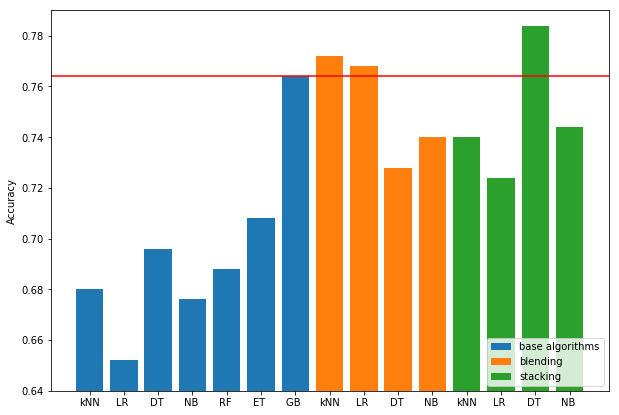

In [181]:
ymin = min(a[:,0].min(),b[:,0].min(),c[:,0].min())
ymax = max(a[:,0].max(),b[:,0].max(),c[:,0].max())

plt.figure(figsize=(10, 7))
plt.bar(np.arange(len(b)),b[:,0], label='base algorithms')
plt.bar(np.arange(7,7+len(a)),a[:,0], label = 'blending')
plt.bar(np.arange(11,11+len(c)),c[:,0], label = 'stacking')
plt.ylim([ymin.round(2)-0.01, ymax.round(2)+0.01])
plt.axhline(y=b[:,0].max(), color='r')
plt.ylabel('Accuracy')
plt.xticks(np.arange(7+len(a)+len(c)), clfs_labels + metas_labels + metas_labels)
plt.legend(loc=4)


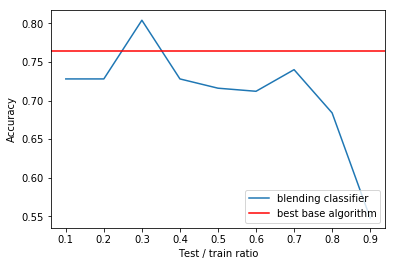

In [222]:
# How accuracy of Blending Classifier depends on train / test ratio?
r1 = []
for k in range (1,10):
    sc = BlendingClassifier(clfs,LogisticRegression(),test_ratio = k/10)
    sc.fit(X_train,y_train)
    p = sc.predict(X_test)
    r1.append(accuracy_score(y_test, p))
plt.plot(r1, label = 'blending classifier')
plt.axhline(y=b[:,0].max(), color='r', label = 'best base algorithm')
plt.ylabel('Accuracy')
plt.xlabel('Test / train ratio')
plt.xticks(np.arange(len(r1)), np.linspace(0.1,0.9,9))
plt.legend(loc=4)

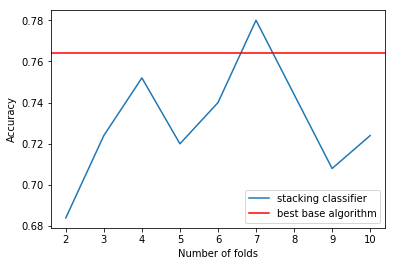

In [214]:
# How accuracy of Stacking Classifier depends on number of folds?
r2 = []
for n_folds in range (2,11):
    sc = StackingClassifier(clfs,DecisionTreeClassifier(),n_folds = n_folds)
    sc.fit(X_train,y_train)
    p = sc.predict(X_test)
    r2.append(accuracy_score(y_test, p))
plt.plot(r2, label = 'stacking classifier')
plt.axhline(y=b[:,0].max(), color='r', label = 'best base algorithm')
plt.ylabel('Accuracy')
plt.xlabel('Number of folds')
plt.xticks(np.arange(len(r2)), range(2,11))
plt.legend(loc=4)